In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis
* choose vacation to start at 08/24/2017 to 08/31/2017
* so last 12 months prior to tirp's start date will be 08/24/2016 to 08/23/2017

[]

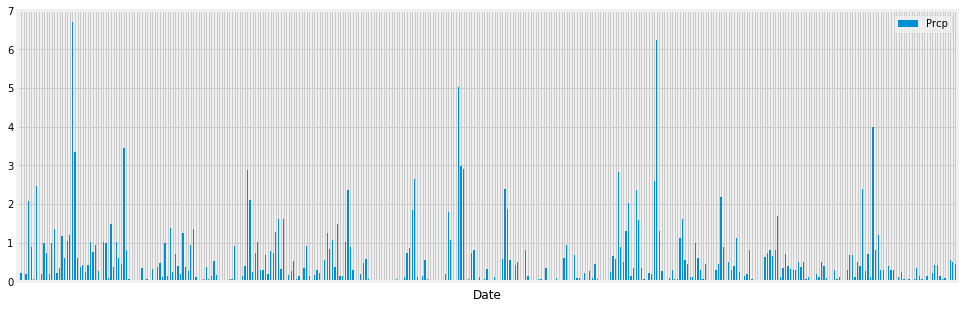

In [10]:
# Design a query to retrieve the last 12 months of precipitation data prior to your 
#trips start date and plot the results

# Perform a query to retrieve the date and prcp values
vacation_date = dt.date(2017,8,24)
pre_vacation_year_end = dt.date(2017,8,23)
pre_vacation_year_start = vacation_date-dt.timedelta(days=365)
result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= pre_vacation_year_end)\
    .filter(Measurement.date >=pre_vacation_year_start).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
result_df = pd.DataFrame(result,columns=["Date","Prcp"])

#use the max prcp of each date 
result_gp = result_df.groupby("Date")
result_gp_df = pd.DataFrame(result_gp["Prcp"].max())

# Sort the dataframe by date
# already sorted when group by date

# Use Pandas Plotting with Matplotlib to plot the data
result_gp_df.plot(kind="bar",figsize=(15,5))

# Rotate the xticks for the dates
# instead of rotate, I hide the x ticklabels
x_axes = plt.gca()
x_axes.axes.get_xaxis().set_ticklabels([])

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
result_gp_df.describe()

,Prcp
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


In [12]:
# How many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_ls = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.date).desc())
for x in station_ls:
    print(x)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station=="USC00519281").all()




[(54.0, 85.0, 71.66378066378067)]

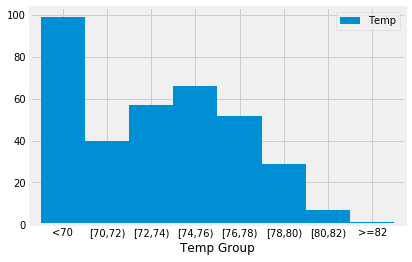

In [44]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data previous to your 
# trips start date for this station and plot the results as a histogram
result_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date <= pre_vacation_year_end)\
    .filter(Measurement.date >=pre_vacation_year_start).filter(Measurement.station=="USC00519281").all()
result_temp_df = pd.DataFrame(result_temp,columns=["Date","Temp"])

#use the max tobs of each date 
result_temp_gp = result_temp_df.groupby("Date")
result_temp_gp_df = pd.DataFrame(result_temp_gp["Temp"].max())
bins=[0,70,72,74,76,78,80,82,200]
group_names = ["<70","[70,72)","[72,74)","[74,76)","[76,78)","[78,80)","[80,82)",">=82"]
result_temp_gp_df["Temp Group"]=pd.cut(result_temp_gp_df["Temp"],bins,labels=group_names)
temp_gp =result_temp_gp_df.groupby("Temp Group")
temp_gp_df = pd.DataFrame(temp_gp["Temp"].count())
temp_gp_df.plot(kind="bar",rot=0,width=1)


In [28]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-24', '2016-08-31'))


[(71.0, 78.11538461538461, 84.0)]


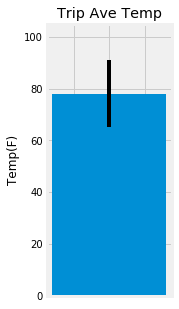

In [62]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
[(temp_min,temp_avg,temp_max)]=calc_temps('2016-08-24', '2016-08-31')
plt.figure(figsize=(2,5))
plt.bar(x=0,height=temp_avg,align="center",yerr=(temp_max-temp_min))
plt.ylim(0,105)
plt.title("Trip Ave Temp")
plt.ylabel("Temp(F)")
x_axes = plt.gca()
x_axes.axes.get_xaxis().set_ticklabels([])
plt.show()

In [15]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station, Station.name,Station.latitude, Station.longitude, Station.elevation,func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).filter(Measurement.date>='2016-08-24').filter(Measurement.date<='2016-08-31').\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.04),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.5300000000000002),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.85),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.5),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.8199999999999998),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.30000000000000004),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)]

## Optional Challenge Assignment

In [16]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
